### Step 1: Find and create a genus-0 reference surface, $S_{ref}(x,y,z)$

From the extracted cell surface, $S(x,y,z)$, we will find a reference shape using curvature-minimizing flow using a free-form deformation algorithm, [conformalized mean curvature flow](https://arxiv.org/pdf/1203.6819) (cMCF). 

Conceptually, this involves:

1. run cMCF on $S(x,y,z)$ for $N$ iterations to generate $N+1$ shapes (including the input)
2. applying a selection/stopping criteria to pick the best shape for the desired reference
    - Typically, we measure and monitor the mean absolute value [discrete Gaussian curvature](https://www.cs.jhu.edu/~misha/Fall09/4-surfaces.pdf) of mesh vertices at each iteration. 
        - Discrete Gaussian curvature is a topological property of the shape that is independent of the meshing of the surface and unlike mean curvature also independent of scale. 
        - Discrete Gaussian curvature of a vertex is defined as the angle deficit between the sum of the triangle angles incident to the vertex from $360^0$ (or $2\pi$ radians). 

        $$ \text{Discrete Gaussian curvature of a vertex}, K = 2\pi - \sum(\text{incident triangle angles})$$ 
        
        - K = 0 if surface is flat
        - K > 0 if surface has positive curvature
        - K < 0 if surface has negative curvature
    - We empirically $\langle |K| \rangle$ behaves like a 'shape state' parameter, whereby its changepoints identify significant changes in the surface mesh corresponding to significant changes in shape.
    - We identify changepoints in $\langle |K| \rangle$ to generate (possibly multiple) candidate reference shapes
        - for analyzing morphological motifs, we take the 1st candidate shape will be 'closest' appearance-wise to $S(x,y,z)$
    - There are many alternatives to define a stopping criteria for curvature-minimizing flows which we discuss in the specific chapter on finding reference e.g:
        - rate of change in $\langle |K|\rangle$ between successive iterations used in the paper
        - [chamfer distance](https://fwilliams.info/point-cloud-utils/sections/shape_metrics/) between input surface and mesh at each iteration   
3. genus-0 shrinkwrapping, voxelization and remeshing the discovered reference shape to construct its genus-0 surface, $S_{ref}(x,y,z)$. 

**cMCF Warning Note**: cMCF will not work if your mesh is multiple-component, describing multiple independent surfaces. In this example, we will enforce single-component when reading the mesh file, see: `unwrap3D.Mesh.meshtools.read_mesh`. Otherwise, cMCF is intended for watertight meshes, but we have found it is generally robust to imperfect meshes, tolerating it not being watertight and having holes, particularly when additionally using the [robust Laplacian](https://github.com/nmwsharp/nonmanifold-laplacian) instead of the standard cotangent Laplacian. However cMCF may terminate earlier than the specified $N$ iterations. 

**Shrinkwrapping advice note**: Shrinkwrapping is an essential step for complex surfaces to guarantee large holes, and handles are covered and made genus-0. However, it adds significant compute time. When your chosen reference shape is devoid of large holes and protrusions i.e is convex, such as the example surface here, shrinkwrapping will not add value, and any small holes should be filled by adjusting the voxelization settings.    

#### 1. Read in surface mesh, $S(x,y,z)$

We assume the user has worked through step 0 which generates and saves a cell surface mesh to the folder `example_results/bleb_example/step0_cell_segmentation`. Furthermore, this cell surface has been colored by curvature and molecular intensity. 

In [15]:
import unwrap3D.Utility_Functions.file_io as fio
import unwrap3D.Mesh.meshtools as meshtools
import numpy as np
import os 
import scipy.io as spio
import skimage.io as skio

"""
Preamble: setting up the folders
"""
# example cell used
imgfolder = '../../data/img'
imgfile = os.path.join(imgfolder, 'bleb_example.tif')
basefname = os.path.split(imgfile)[-1].split('.tif')[0] # get the filename with extension

# create the analysis save folder for this step
savefolder = os.path.join('example_results', 
                         basefname,
                         'step1_cMCF_reference')
fio.mkdir(savefolder) # auto generates the specified folder structure if doesn't currently exist.


"""
Loading results from previous step
"""
# load the pre-generated cell surface mesh for the cell
cell_surface_folder = 'example_results/%s/step0_cell_segmentation' %(basefname)
cell_surface_file = os.path.join(cell_surface_folder, 
                                'curvature_binary_mesh_%s.obj' %(basefname)) 
mesh = meshtools.read_mesh(cell_surface_file)

# also load the molecular signal (PI3K) colored cell surface mesh for the cell for added visualization
cell_surface_file_PI3K = os.path.join(cell_surface_folder, 
                                'PI3K_binary_mesh_%s.obj' %(basefname)) 
PI3K_mesh = meshtools.read_mesh(cell_surface_file_PI3K)

# load the binary from which the cell surface mesh was derived from 
cell_binary_file = os.path.join(cell_surface_folder,
                                'bleb_example_binary_seg.tif')
cell_binary = skio.imread(cell_binary_file)


#### 2. Run conformalized mean curvature flow (cMCF) on $S(x,y,z)$

Conformalized mean curvature flow (cMCF) is a variant of [mean curvature flow](https://en.wikipedia.org/wiki/Mean_curvature_flow) proposed by [Kazhdan et al.](https://arxiv.org/abs/1203.6819). The flow iteratively smooth high curvature surface features with the point (effectively 3D sphere) as the convergence limit. This has the property of seeking surfaces of minimial local surface area (also called [minimal surfaces](https://en.wikipedia.org/wiki/Minimal_surface)). 

cMCF does not change the topology of $S(x,y,z)$. However, the minimal area property shrinks higher genus mesh features such as holes and handles, and improves their convexity which means we can much more efficiently apply shrinkwrapping (significantly less iterations) with voxelization to obtain a genus-0 reference surface, $S_{ref}(x,y,z)$ compared to first performing shrinkwrapping on $S(x,y,z)$ then doing cMCF.

**cMCF Note:** By default, we use the cotangent Laplacian for cMCF. If you get less iterations than specified, try re-running with the robust Laplacian proposed by [Sharpe et al.](https://www.cs.cmu.edu/~kmcrane/Projects/NonmanifoldLaplace/NonmanifoldLaplace.pdf) by setting the parameter `robust_L=True`.

In [16]:
# run cMCF on the mesh for 50 iterations, delta=5e-4 using the standard cotangent Laplacian
# delta governs speed of flow, without adjusting the number of iterations, saving computation time. decrease delta for less smoothing, increase for more. 
Usteps_MCF_img, mesh_F, MCF_measures_dict = meshtools.conformalized_mean_curvature_flow(mesh, 
                                                                                    max_iter=50, 
                                                                                    rescale_output = True, # cMCF is solved in normalized coordinates, when True, the output will be rescaled to be in image coordinates.  
                                                                                    delta=5e-4, 
                                                                                    conformalize=True, # set this flag to run cMCF, else it will run MCF
                                                                                    robust_L =False, # if set, runs MCF/cMCF using the robust Laplacian instead of cotangent Laplacian
                                                                                    mollify_factor=1e-5, # this is a parameter used in the robust Laplacian
                                                                                    solver='pardiso')  # 'scipy': standard scipy solver, 'pardiso' for using Intel's pardiso solver to solve in parallel. 'pariso' is much faster. But you must use 'scipy' if you plan to multiprocess over different cells.

    
"""
Save the output
"""
# save the vertex positions with face connectivity
spio.savemat(os.path.join(savefolder, 
                          'MCF_iterations_'+basefname+'.mat'), 
              {'v': Usteps_MCF_img, # rescaled image coordinates, since we ran with rescale_output=True(default)
               'f': mesh_F}) # face connectivity

# save the convergence measures. We computed several but found the mean absolute discrete Gaussian curvature (<|K|>) to best serve as a 'shape state' parameter
spio.savemat(os.path.join(savefolder, 
                          'MCF_convergence_measures_'+basefname +'.mat'),
                           MCF_measures_dict) 


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:01<00:00,  1.22s/it]


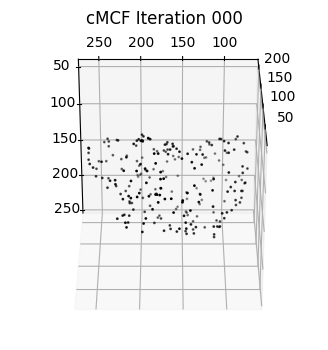

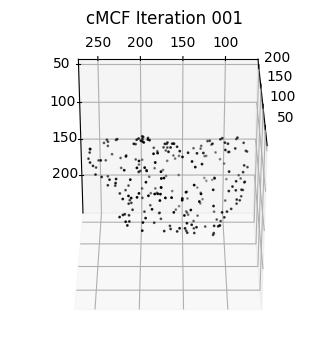

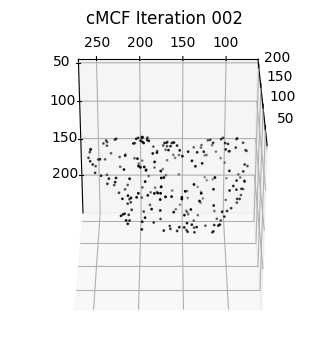

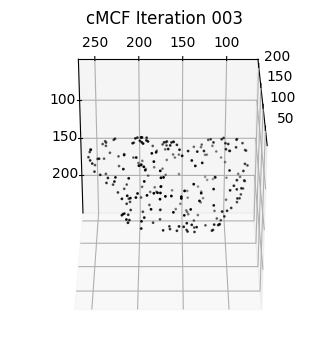

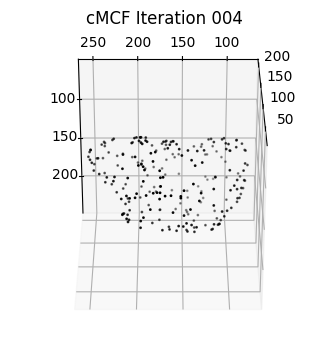

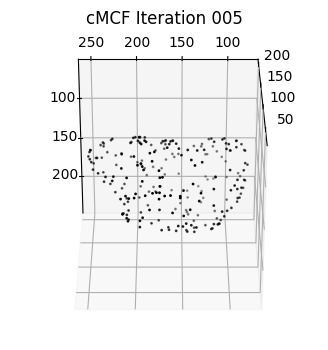

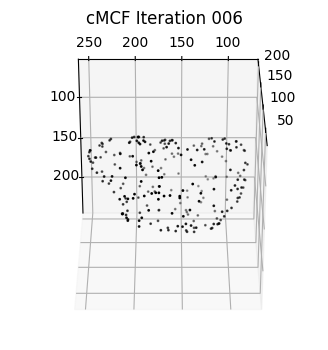

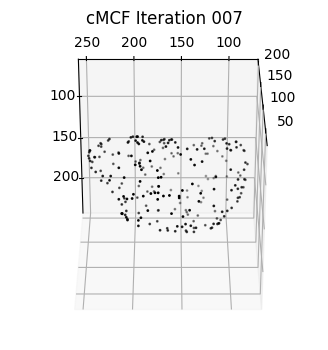

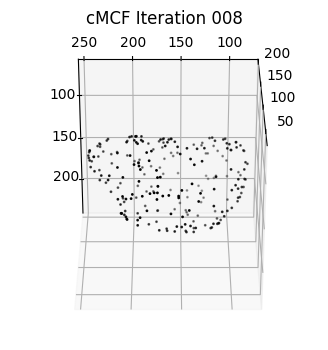

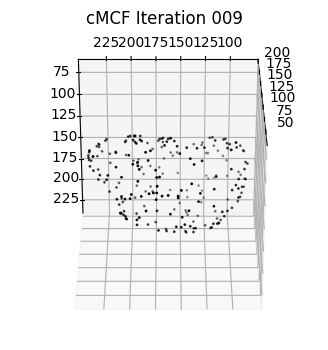

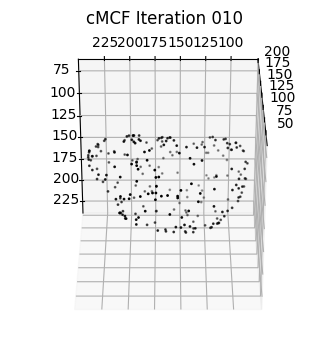

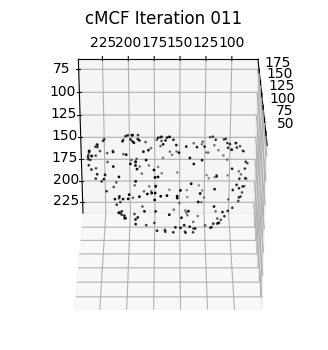

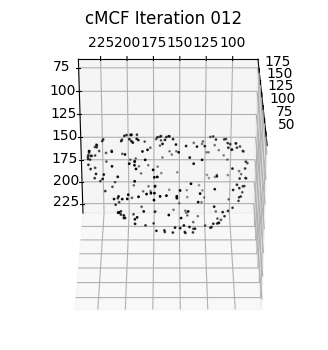

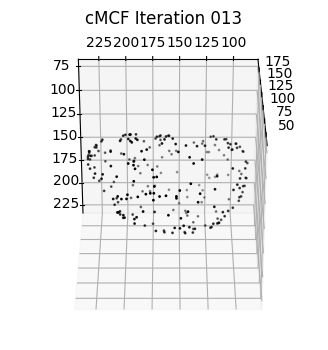

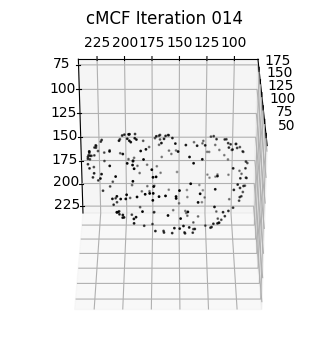

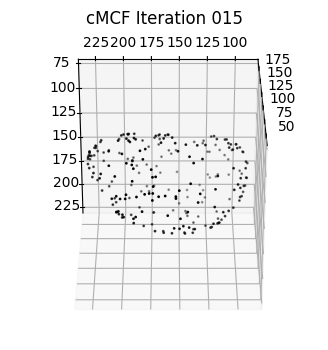

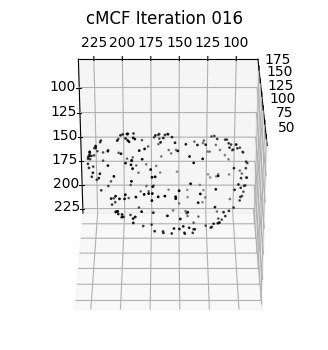

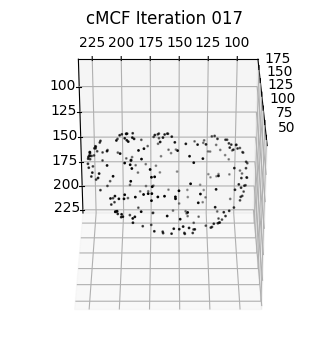

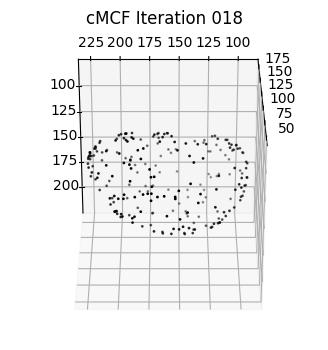

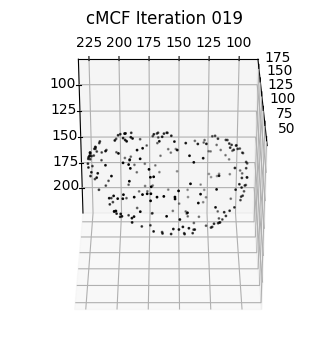

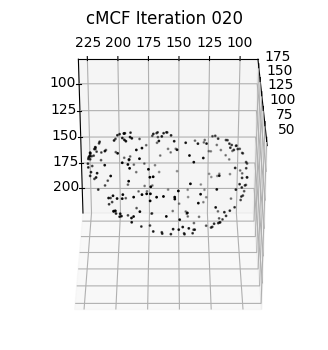

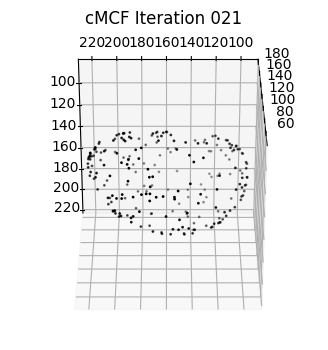

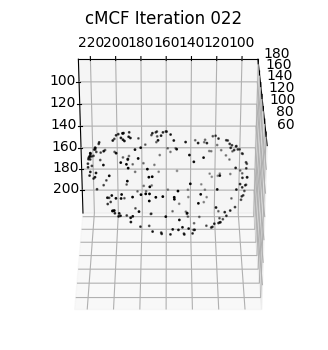

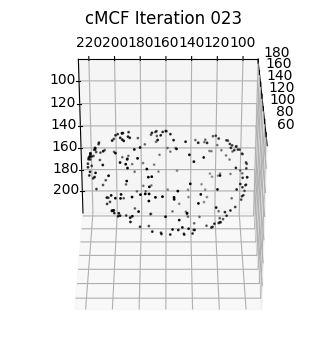

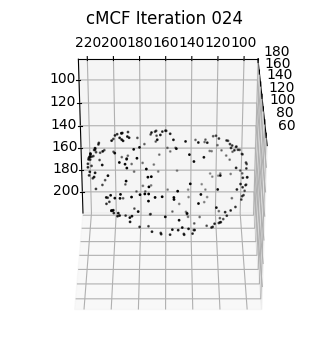

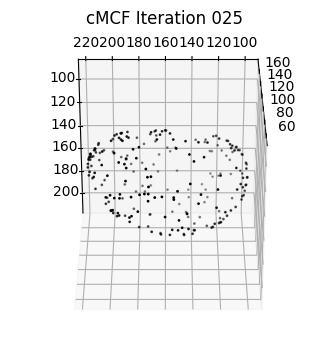

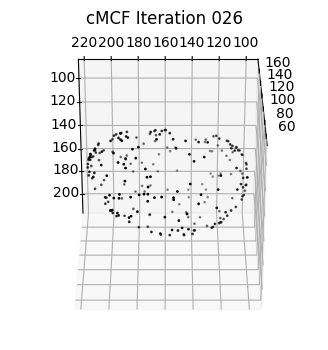

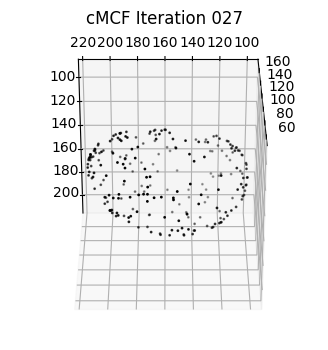

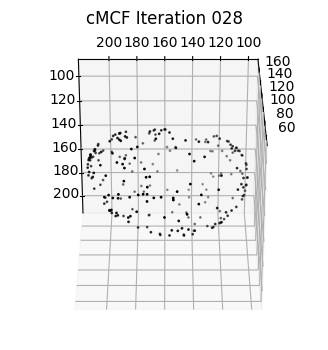

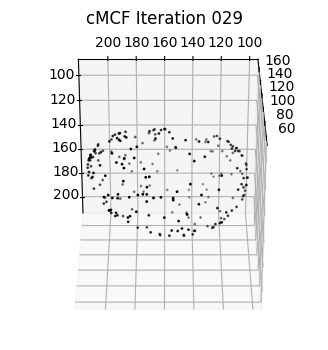

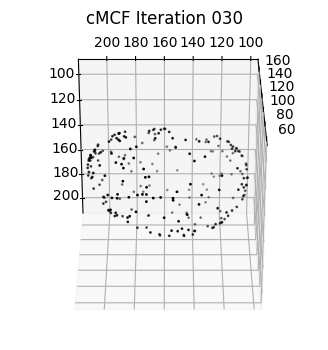

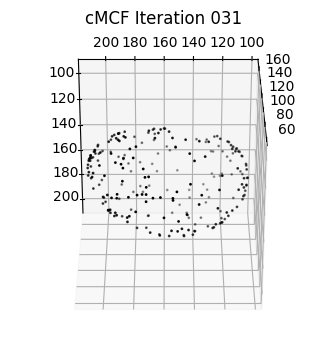

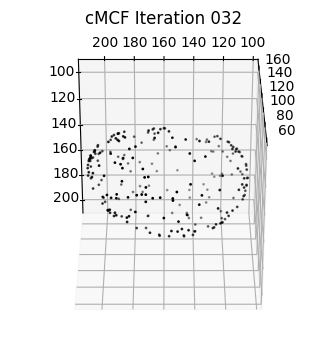

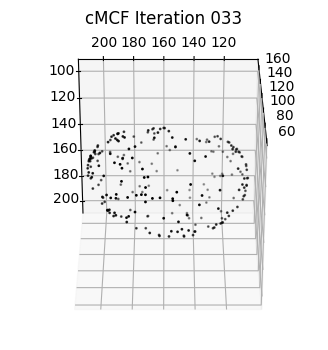

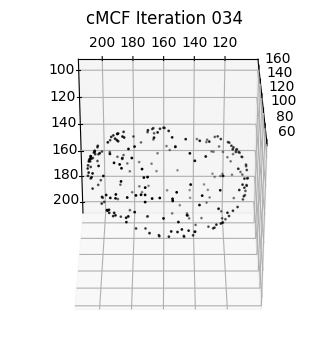

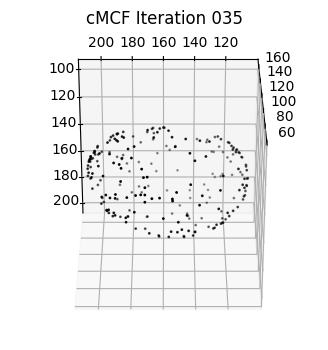

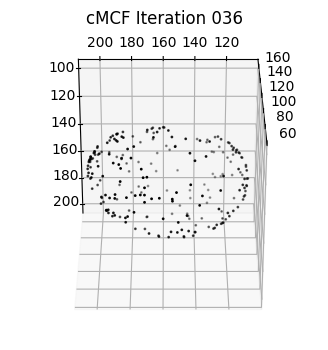

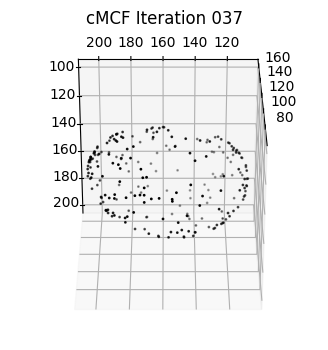

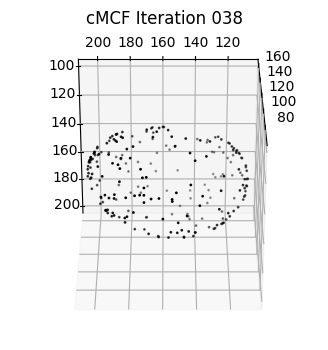

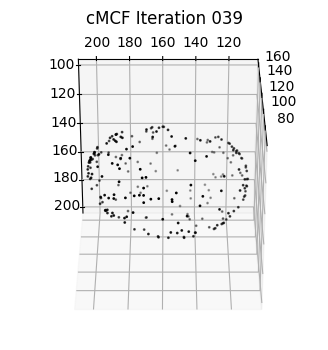

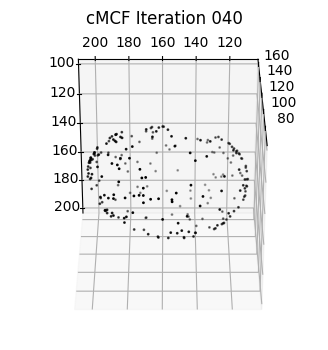

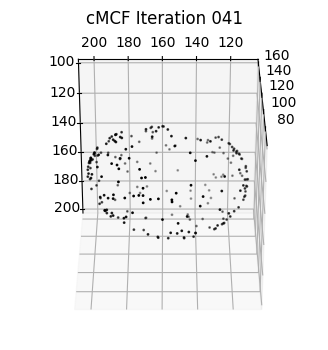

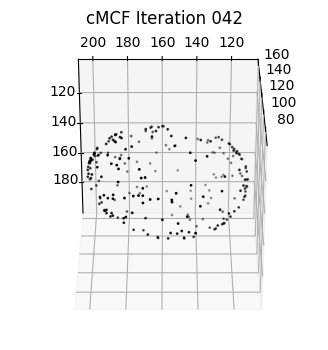

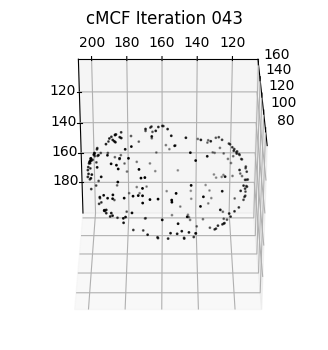

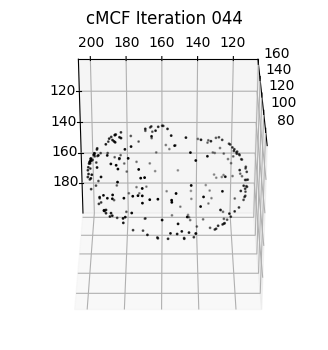

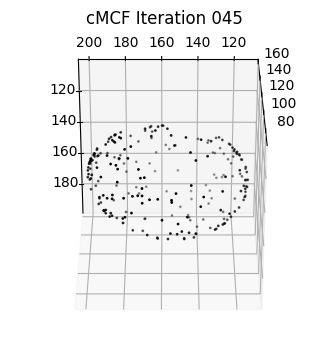

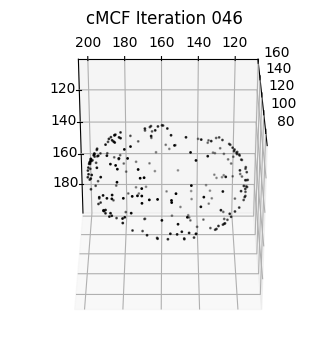

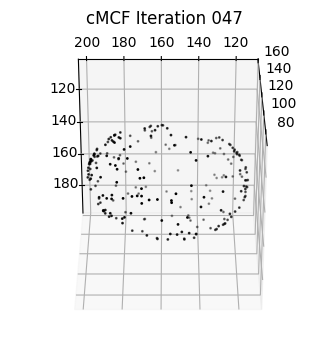

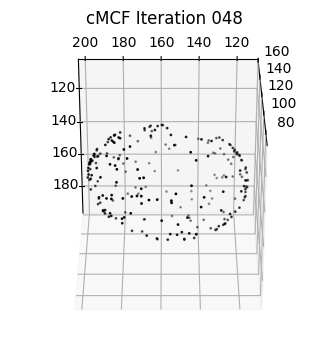

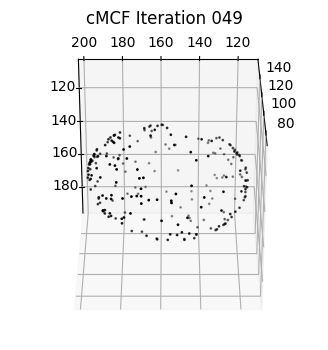

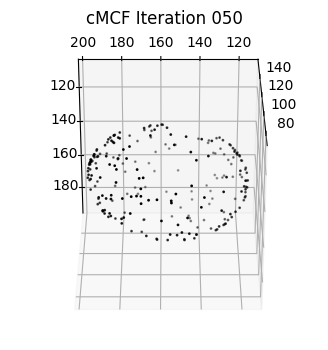

In [17]:
"""
Visualizing and saving (optional) of intermediate surfaces at each iteration of the flow
"""
import unwrap3D.Visualisation.plotting as plotting
import pylab as plt 

# cMCF does not change the mesh face topology, the output is thus an array of vertex positions corresponding to each iteration of flow.
# optionally we can save each iteration to meshes that can be loaded into e.g. meshlab and snapshotted to make a movie
# to do this uncomment the following lines. 

save_MCF_folder = os.path.join(savefolder, 'cMCF_flow_curvature'); fio.mkdir(save_MCF_folder)

# iterate over the cMCF iterations.
for ii in np.arange(Usteps_MCF_img.shape[-1])[:]:
    
    # Curvature mesh
    MCF_mesh = meshtools.create_mesh(vertices=Usteps_MCF_img[...,ii], 
                                    faces=mesh_F, 
                                    vertex_colors=mesh.visual.vertex_colors) # copy the colors of the original
    tmp = MCF_mesh.export(os.path.join(save_MCF_folder, 'curvature_iter_'+str(ii).zfill(3)+'.obj')) # variable assignment to prevent printing

    # PI3K mesh
    MCF_mesh_PI3K = meshtools.create_mesh(vertices=Usteps_MCF_img[...,ii], 
                                        faces=mesh_F, 
                                        vertex_colors=PI3K_mesh.visual.vertex_colors) # copy the colors of the original
    tmp = MCF_mesh_PI3K.export(os.path.join(save_MCF_folder, 'PI3K_iter_'+str(ii).zfill(3)+'.obj')) # variable assignment to prevent printing

    
    # also take a look through matplotlib 
    sampling = 100 # plot every just so its not fully dense in the plot so we don't see anything!

    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(projection='3d')
    plt.title('cMCF Iteration '+str(ii).zfill(3))
    ax.scatter(MCF_mesh.vertices[::sampling,2], 
               MCF_mesh.vertices[::sampling,1],
               MCF_mesh.vertices[::sampling,0], 
               s=1, 
               c='k')
    ax.view_init(-60, 180)
    plotting.set_axes_equal(ax)
    plt.show()

#### 3. Automatic reference shape determination using discrete Gaussian curvature

We would like to select a shape which is closest to the input $S(x,y,z)$ with surface protrusions smoothed out, in this case the blebs. We do this by finding potential changepoints in the curve of the mean absolute discrete Gaussian curvature. The changepoint algorithm we use is to detect peaks after subtracting the curve from its baseline inferred by moving window average. This may generate one or multiple shape candidates. For the closest fit, we select the first candidate.

**Comment:** 
In the paper, we initially described monitoring the rate of change in mean absolute vertex discrete Gaussian curvature to determine the iteration number of cMCF. The cutoff however is difficult to set for different protrusion types, the rate of change behaves weirdly (does not necessarily decay) when surface mesh is not watertight and manifolder, and does not give the closest surface to $S(x,y,z)$ without surface protrusions. We used this initially because we had not developed shrinkwrapping and needed to run more iterations to find a shape that could be made genus-0 with voxelization only. 

possible iteration numbers for reference shape:
[4]


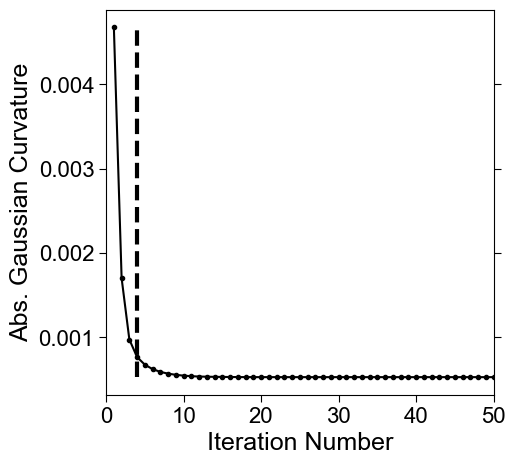

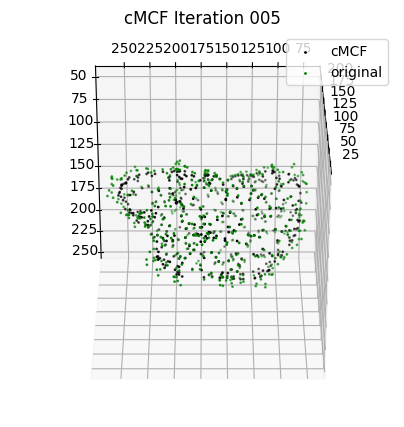

In [18]:
# load the mean absolute Gaussian curvature at vertices at each iteration of the cMCF
gauss_curve_MCF = MCF_measures_dict['gauss_curvature_iter'].copy()

# find changepoints in the curve, generally default is fine.
inds = meshtools.find_all_curvature_cutoff_index(gauss_curve_MCF, 
                                                 avg_fnc=np.nanmean, # use moving means 
                                                 absval=True, # absolute value after subtracting baseline 
                                                 winsize=11, # window size for moving means, larger tends to slightly bias the found iteration number to later 
                                                 min_peak_height=1e-7, # minimum peak height
                                                 min_peak_distance=5) # minimal distance between detected peaks. 

print('possible iteration numbers for reference shape:')
print(inds)

# # Alternative, rate-of-change: (used in the paper for validation, now deprecated, not recommended)
# threshold_cMCF = 5e-7
# # determine the cut off iteration number such that the change between the previous iteration drops below 5e-7
# ind = meshtools.find_curvature_cutoff_index( gauss_curve_MCF, 
#                                               thresh=threshold_cMCF,  # cutoff on the rate of change.
#                                               absval=True) 

# plot the found inds onto the curve
"""
plot the evolution of the curve and mark all found iteration numbers
"""
import pylab as plt 

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(np.arange(1,len(gauss_curve_MCF)+1), 
          gauss_curve_MCF, '.-', color='k')
for ind in inds:
    plt.vlines(ind, 
                np.min(gauss_curve_MCF), 
                np.max(gauss_curve_MCF), 'k', linestyles='dashed', lw=3)
plt.tick_params(length=5, right=True)
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.xlim([0,50])
plt.xlabel('Iteration Number', fontsize=18, fontname='Arial')
plt.ylabel('Abs. Gaussian Curvature', fontsize=18, fontname='Arial')
plt.savefig(os.path.join(savefolder, 
                          'MCF_iterations_'+basefname.replace('.tif', '.svg')), bbox_inches='tight')
plt.show()

"""
plot the vertices of the shape at all found iteration numbers 
"""
n_inds = len(inds)
sampling = 50

fig = plt.figure(figsize=( n_inds*5, 5))
# generate subplots
for ind_ii, ind in enumerate(inds):
    ax = fig.add_subplot(1, len(inds), ind_ii+1, projection='3d')
    plt.title('cMCF Iteration '+str(ind+1).zfill(3))
    ax.scatter(Usteps_MCF_img[...,ind][::sampling,2], 
               Usteps_MCF_img[...,ind][::sampling,1],
               Usteps_MCF_img[...,ind][::sampling,0], 
               s=1, 
               c='k', label='cMCF')
    ax.scatter(Usteps_MCF_img[...,0][::sampling,2], 
               Usteps_MCF_img[...,0][::sampling,1],
               Usteps_MCF_img[...,0][::sampling,0], 
               s=1, 
               c='g', label='original')
    ax.view_init(-60, 180)
    plt.legend()
    plotting.set_axes_equal(ax)

plt.show()

# choose the first as the closest shape
if len(inds)>0:
    ind = inds[0]
else:
    ind = 0

# add the determined index to the MCF_measures_dict and resave. 
MCF_measures_dict['cMCF_ind'] = ind
MCF_measures_dict['cMCF_all_inds'] = inds
spio.savemat(os.path.join(savefolder, 
                          'MCF_convergence_measures_'+basefname +'.mat'),
                           MCF_measures_dict)
    

#### 4. Quantifying conformal and equiareal distortion errors during cMCF

We can measure the conformal and equiareal distortion error at each cMCF iteration relative to the initial surface $S(x,y,z)$. 

**Note:** This is slow, and we don't do this normally. It is here for completeness, demonstrating how to compute these measures with u-Unwrap3D if we wish and to show that these flows distorts local surface area, and to a less extent the aspect ratio of triangles.

In [19]:
conformal_error_flow = [meshtools.quasi_conformal_error(Usteps_MCF_img[...,0], Usteps_MCF_img[...,steps], mesh.faces) for steps in np.arange(Usteps_MCF_img.shape[-1])]
area_distortion_error_flow = [meshtools.area_distortion_measure(Usteps_MCF_img[...,0], Usteps_MCF_img[...,steps], mesh.faces) for steps in np.arange(Usteps_MCF_img.shape[-1])]

# figure out how to save out these information.
conformal_error_flow_arrays = [ np.array([cc[jj] for cc in conformal_error_flow]) for jj in np.arange(len(conformal_error_flow[0]))]
area_distortion_error_flow = np.array(area_distortion_error_flow) 

spio.savemat(os.path.join(savefolder, 
                          'MCF_conformal_area_errors.mat'), 
                          {'conformal_Jac_eigvals': conformal_error_flow_arrays[0], 
                          'conformal_stretch_factors': conformal_error_flow_arrays[1], # this is the per face conformal error. 
                          'mean_conformal_stretch_factors': conformal_error_flow_arrays[2], # this is the mean conformal error at each iteration
                          'conformal_tri_area_pairs': conformal_error_flow_arrays[3], 
                          'conformal_area_distortion_factor': area_distortion_error_flow}) # this is the per face equiareal error. 
    

Plot the mean conformal (left axis) and equiareal distortion (right axis) errors as a function of the cMCF iteration number.

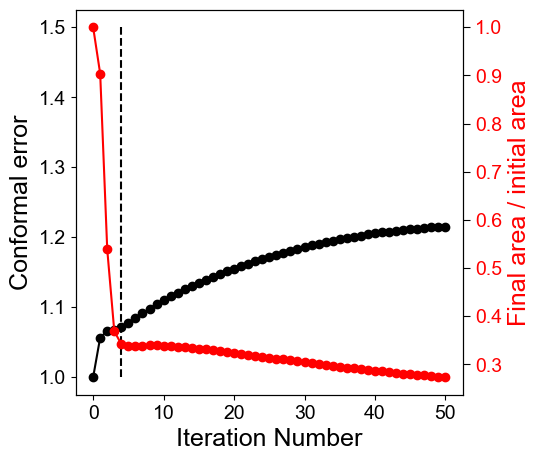

In [20]:
mean_conformal_error_curve = conformal_error_flow_arrays[2].copy()
mean_area_errors_curve = area_distortion_error_flow.mean(axis=1).copy()

# plot the errors as a function of iteration number 
fig, ax1 = plt.subplots(figsize=(5,5))
ax1.set_xlabel('Iteration Number', fontsize=18, fontname='Arial')
ax1.set_ylabel('Conformal error', fontsize=18, fontname='Arial', color='k')
ax1.plot(np.arange(len(mean_conformal_error_curve)), mean_conformal_error_curve, 'ko-')
ax1.vlines(ind,1,1.5, linestyles='dashed', color='k')
ax1.tick_params(axis='y', labelcolor='k')
plt.xticks(fontname='Arial', fontsize=14)
plt.yticks(fontname='Arial', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Final area / initial area', fontsize=18, color='r', fontname='Arial')  # we already handled the x-label with ax1
ax2.plot(np.arange(len(mean_area_errors_curve)), 1./mean_area_errors_curve, 'ro-')
ax2.tick_params(axis='y', labelcolor='r')
plt.xticks(fontname='Arial', fontsize=14)
plt.yticks(fontname='Arial', fontsize=14)
plt.tick_params(length=5)
plt.savefig(os.path.join(savefolder,  
                       'mean_MCF_errors_iterations_'+basefname+'.png'), bbox_inches='tight', dpi=300)
plt.show()

#### 5. Quantifying the conformal and equiareal distortion error of $S_{ref}(x,y,z)$ 

In practice, we do not need to compute the errors for every cMCF iteration. We are mostly interested in the error for the chosen shape, $S_{ref}(x,y,z)$. The code below demonstrates the computation, then colormapping of the values to display on the surface mesh of $S_{ref}(x,y,z)$.

In [21]:
import unwrap3D.Visualisation.colors as vol_colors
from matplotlib import cm 

"""
conformal error
"""
conformal_error = meshtools.quasi_conformal_error(Usteps_MCF_img[...,0], 
                                                  Usteps_MCF_img[...,ind], 
                                                  mesh.faces)
# color mapping S(x,y,z) using a 1-1.5 scale in jet.
conformal_error_colors = vol_colors.get_colors(conformal_error[1], colormap=cm.jet, vmin=1., vmax=1.5)

img_binary_conformal_colors = meshtools.create_mesh(vertices=Usteps_MCF_img[...,0],
                                                  faces=mesh.faces,
                                                  face_colors=np.uint8(255*conformal_error_colors[:,:3])) # note we set the face_colors 
tmp = img_binary_conformal_colors.export(os.path.join(savefolder,
                                                'curvature_cMCF_conformal_error.obj'))
# also color the cMCF shape. 
img_binary_conformal_colors.vertices = Usteps_MCF_img[...,ind].copy()
tmp = img_binary_conformal_colors.export(os.path.join(savefolder, 
                                           'curvature_cMCF_conformal_error_Sref.obj'))
"""
equiareal distortion error
"""
area_distortion_error = meshtools.area_distortion_measure(Usteps_MCF_img[...,0], # original
                                                          Usteps_MCF_img[...,ind], # cMCF
                                                          mesh.faces)

# color mapping S(x,y,z) the -log(area fraction) using a -3 to 3 scale in reverse coolwarm so that negative means the original surface has been compressed whilst a positive value means the original surface has been expanded.
area_distortion_error_colors = vol_colors.get_colors(-np.log(area_distortion_error), 
                                                      colormap=cm.coolwarm_r, 
                                                      vmin=-3, vmax=3)

img_binary_area_colors = meshtools.create_mesh(vertices=Usteps_MCF_img[...,0],
                                              faces=mesh.faces,
                                              face_colors=np.uint(255*area_distortion_error_colors[:,:3])) 
tmp = img_binary_area_colors.export(os.path.join(savefolder, 
                                           'curvature_MCF_paper_area_error.obj'))

# also color the cMCF shape. 
img_binary_area_colors.vertices = Usteps_MCF_img[...,ind].copy()
tmp = img_binary_area_colors.export(os.path.join(savefolder, 
                                           'curvature_MCF_paper_area_error_Sref.obj'))


#### 6. Constructing a genus-0 $S_{ref}(x,y,z)$ surface using shrinkwrapping and voxelization

If the $S_{ref}(x,y,z)$ from cMCF is not genus-0, we cannot map it to a sphere. Practically, area-distortion relaxation will fail due to numerical instability if any protrusive features of $S_{ref}(x,y,z)$ is sharp (high curvature, point-like) or its shape has very thin 'necks' even if it genus-0. 

Shrinkwrapping guarantees the construction of a genus-0 $S_{ref}(x,y,z)$ surface, whilst voxelization allows the use of morphological operations, particularly dilation to remove sharp points and thin necks that would later prevent obtaining an equiareal spherical parameterization after step 4 of the u-Unwrap3D standard workflow. 

**Shrinkwrapping**

As the name suggests, we shrinkwrap an initial genus-0 surface (i.e. without cutting, tearing etc) to obtain a genus-0 equivalent of the target shape. This is an iterative procedure involving the following steps:

1. Compute a good initial genus-0 surface using [alphawrap](https://doc.cgal.org/latest/Alpha_wrap_3/index.html) and interval bisection, `see unwrap3D.Mesh.meshtools.alphawrap_genus0`.  
2. Compute the [gradient vector field](https://en.wikipedia.org/wiki/Gradient_vector_flow) of input surface and deform the initial genus-0 surface using active contours to refine to input surface for a number of epochs.
3. Detect local areas where shrinkwrapping has yet to converge because flow is hindered by large concavities and triangle quality has become poor c.f. [gradient vector flow convergence](https://en.wikipedia.org/wiki/Gradient_vector_flow). Remove triangles in these regions, stitch the gap and remesh whilst remaining genus-0. Repeat 2 above to refine again. Repeat 3 and 2 as needed until convergence. For challenging morphologies with long and narrow concavities, this might be 4, 5 times.  

**N.B:** Whilst the shrinkwrapping approach we developed in u-Unwrap3D is accurate, it is also slow because it runs on an image grid, therefore we wouldn't perform if the cMCF $S_{ref}(x,y,z)$ was already genus-0 or has only small holes and handles that can be readily fixed by voxelization and morphological operations. Similarly if the initial genus-0 surface is already sufficient (true for largely-convex shapes), skip steps 2,3 in the shrinkwrapping. You can also significantly boost speed, if you downsize the mesh so that vertices correspond to a smaller image volume.

**Voxelization**

Voxelizing the mesh i.e. convert it to a binary volume image enables us to use binary morphological operations to easily close small holes and handles, fill in internal volume and dilate to remove sharp protrusive features and widen narrow necks. Voxelization in u-Unwrap3D works by:

1. upsampling the input mesh to have minimum edge length < 2 voxels and rasterization onto a image grid.
2. dilating the binary by $k_{\text{dilate}}$ voxels, 
3. binary infill holes
4. eroding by $k_{\text{erode}}$ voxels. 

The steps above are made available in a single function, `unwrap3D.Mesh.meshtools.voxelize_image_mesh_pts`.

After these operations, we re-extract the surface mesh of the binary volume to get a genus-0 $S_{ref}(x,y,z)$ suitable for spherical parameterization.

**NOTE**: In this example, both shrinkwrapping and voxelization is extraneous steps. The original mesh is already genus-0, isotropically meshed and its cMCF $S_\text{ref}$ is effectively convex, devoid of any concavities. 

initial: 2
initial_watertight: 2


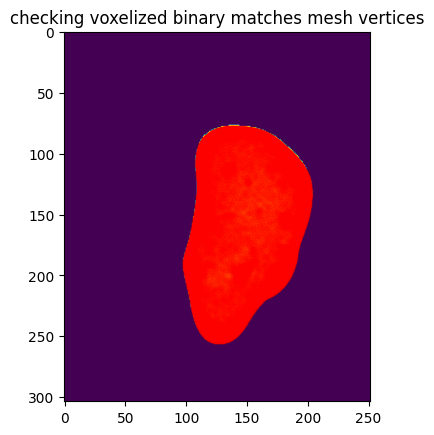

initiating a genus-0 mesh automatically with interval:  [3.004936615559782, 3.0055246926182777]


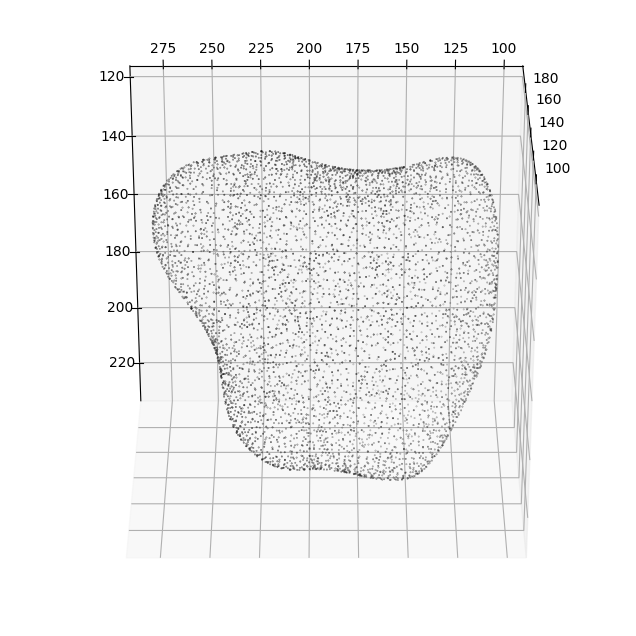

GVF iter: 15/15(82482, 3)


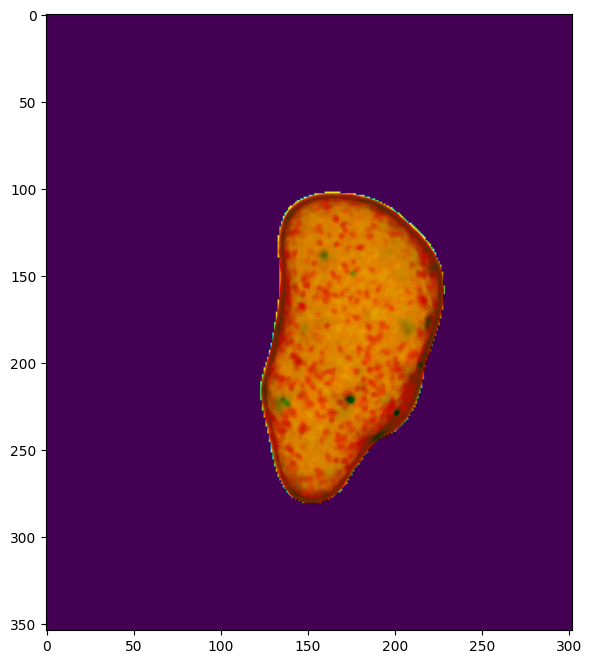

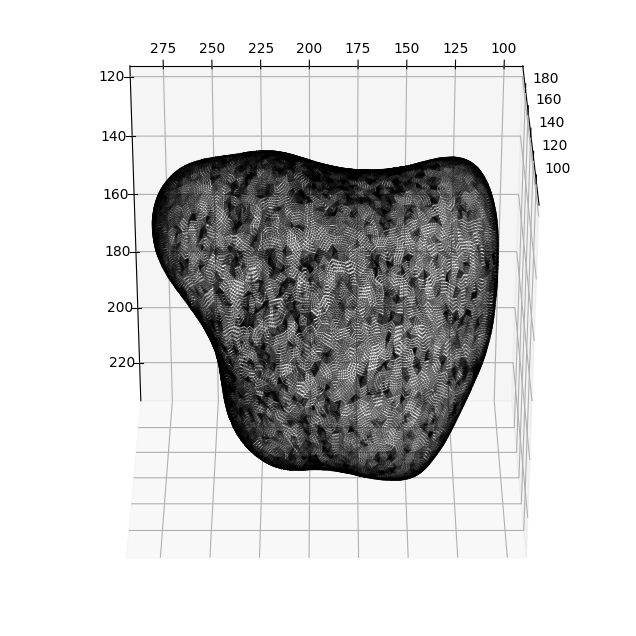

0
0 4.154158643545541 changing lr:  0.75
0 4.154158643545541
1
2
--------------------------
1 3.9342746914386995
2
2
--------------------------
2 3.928994295314892
3
2
--------------------------
3 3.928257314914751
4
2
--------------------------
4 3.930037788270435 changing lr:  0.5625
4 3.930037788270435


findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.
findfont: Font family 'Liberation Sans' not found.


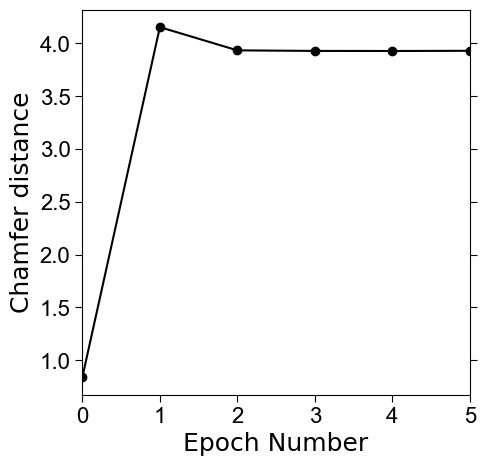

In [22]:
# first explicitly make a mesh of the intermediate S_ref(x,y,z) obtained direct from cMCF.  
cMCF_Sref = meshtools.create_mesh(vertices = Usteps_MCF_img[...,ind],  
                                    faces = mesh.faces,
                                    vertex_colors=mesh.visual.vertex_colors)

save_smooth_mesh_file = os.path.join(savefolder, 
                                     'unwrap_cMCF_smooth_mesh.obj')
tmp = cMCF_Sref.export(save_smooth_mesh_file)


"""
Part 1:

Shrinkwrapping of mesh (steps 1 and 2 only, 3 is commented out and included only for completeness)
    - shrinkwrapping steps 1 and 2 are provided in one single function
    - shrinkwrapping step 3 is dependent on the input and is carried out in a loop. [ we currently have not tested automatic criteria to determine when it is necessary]
"""

"""
# perform shrinkwrap 1 and 2 in one function call (most common usage for cMCF Sref)
"""
# the number of epochs = total_shrinkwrap_iters / remesh_iters. total_shrinkwrap_iters = 200  is good for most shapes, For simple shapes, reduce this number by multiple of remesh_iters. 
# remesh_iters = 10 is good for most, does not require changing.
# make_manifold = True manipulates the input mesh to be watertight first. It results in a less tight shrinkwrap
# decay_rate adjusts the learning rate each epoch by this fraction [the algorithm cycles learning rate to avoid local minima] 
# min_lr ensures learing rate does not decrease beyond this. 

total_shrinkwrap_iters = 50 # we can lower number when the shape is simple, as here, or let it be higher to see if we can get better wrap than initial
decay_rate = 0.75
min_lr = 0.24 # for decay_rate 0.5, this would mean lowest is 0.25.

n_punchout_refinements = 0 # Set this >0 to run shrinkwrapping step 3 - step 2 loop n times for complex shapes with nasty concavities. Not needed here.

# one round is largely sufficient for most cMCF Sref shapes as by definition they should have concavities largely removed. 
mesh_shrinkwrap, mesh_watertight_in, mesh_genus0, iter_stats = meshtools.shrinkwrap_genus0_basic(cMCF_Sref, 
                                                                                                use_GVF=True,
                                                                                                GVF_mu=0.01, 
                                                                                                GVF_iterations=15, 
                                                                                                voxelize_padsize=50,
                                                                                                voxelize_dilate_ksize = 3, # make dilate_ksize > erode_ksize if your mesh doesn't form a complete volume or there is quite a bit of holes.
                                                                                                voxelize_erode_ksize = 2,  
                                                                                                extra_pad=25,
                                                                                                genus0_alpha_frac = 0.15, # default
                                                                                                genus0_alpha_auto = True,
                                                                                                genus0_tol = 1e-3, 
                                                                                                total_shrinkwrap_iters = total_shrinkwrap_iters,
                                                                                                decay_rate = decay_rate,  
                                                                                                remesh_iters=10,
                                                                                                conformalize=False, # use active contours - recommended 
                                                                                                min_size=40e3, # minimum mesh vertices, increase might better cover smaller cavities but greatly increase computational time!
                                                                                                upsample=1, 
                                                                                                min_lr=min_lr, # minimum step_size dropping from 1.
                                                                                                make_manifold = False, # run this. 
                                                                                                watertight_fraction=0.1,
                                                                                                deltaL=5e-4,
                                                                                                alpha=0.1, # controls stiffness
                                                                                                beta=0.5,# controls torsion
                                                                                                solver='pardiso',
                                                                                                curvature_weighting=False, 
                                                                                                debugviz=True) # leave on if you want to see the state of the mesh, otherwise off. 
        
# save out the output for visualization and checking 
tmp=mesh_shrinkwrap.export(os.path.join(savefolder, 
                                        'shrinkwrap_%s_cMCF-Sref.obj' %(basefname))) # this should be same as the last iteration mesh.
tmp = mesh.export(os.path.join(savefolder, 
                               'input_Sref_to_shrinkwrapping_%s.obj' %(basefname)))
tmp = mesh_genus0.export(os.path.join(savefolder, 
                                      'initial_genus0_shrinkwrap_Sref_%s.obj' %(basefname)))
tmp = (iter_stats[2][-1]).export(os.path.join(savefolder,
                                              'shrinkwrap_final-iter_%s_cMCF-Sref.obj' %(basefname)))


# setup save variables ready for step 3 processing. [those stats will append to these]
chamfer_dists = iter_stats[0]
all_meshes_iter_genus0 = iter_stats[1] # this completes the euler number for each iteration - you can check this is 2.
all_meshes_iter = iter_stats[2]
    
# step 3 shrinkwrap code, executed only if n_punchout_refinements>0
mesh_wrap = mesh_shrinkwrap.copy()

# run this a few times. 
for ii in np.arange(n_punchout_refinements): # use more iterations until happy 
    """
    1. detect nonconverged. 
    """
    mesh_wrap = meshtools.remove_nonshrinkwrap_triangles(mesh_wrap,
                                                        mesh,
                                                        q_thresh=0.1,
                                                        max_dist_cutoff=1.25, # this controls the fidelity... 
                                                        sigma_dist_cutoff=2, 
                                                        sigma_area_cutoff=2, # this ? 
                                                        nearest_k=1,
                                                        dilate_voxels=3, # cut more away ? 
                                                        erode_voxels=1,
                                                        minsize=10)
    
    """
    2. re-prop surface. 
    """
    mesh_shrinkwrap, mesh_watertight_in, mesh_genus0, iter_stats = meshtools.attract_surface_mesh(mesh_in=mesh_wrap,
                                                                                                        mesh_ref=mesh, 
                                                                                                        use_GVF=True, 
                                                                                                        GVF_mu=0.01, # this large, introduces noise 
                                                                                                        GVF_iterations=15,
                                                                                                    voxelize_padsize=50, # this is just leave enough padding space 
                                                                                                    voxelize_dilate_ksize = 2, 
                                                                                                    voxelize_erode_ksize = 2, ## was this cos of 3? 
                                                                                                    extra_pad=25,
                                                                                                    tightest_genus0_initial=True,
                                                                                                    genus0_alpha_frac = 0.1,
                                                                                                    genus0_alpha_auto = False,
                                                                                                    genus0_offset = 0.1,
                                                                                                    genus0_tol = 0.1, 
                                                                                                    total_shrinkwrap_iters = 100, # master number of iterations.
                                                                                                    decay_rate = 1., # no decay. 
                                                                                                    remesh_iters=10,
                                                                                                    conformalize=False, # use active contours
                                                                                                    min_size=80000, # minimum mesh vertices
                                                                                                    upsample=1, 
                                                                                                    min_lr=min_lr, # minimum step_size dropping from 1.
                                                                                                    make_manifold = False, # ah.. its prob this too. 
                                                                                                    watertight_fraction=0.1,
                                                                                                    deltaL=5e-4,
                                                                                                    alpha=0.1, # more stiff here and we can break through? 
                                                                                                    beta=0.5,# what if we reduce the bending? 
                                                                                                    solver='pardiso',
                                                                                                    curvature_weighting=False, 
                                                                                                    debugviz=True)
    
    all_meshes_iter.append(iter_stats[2])
    all_meshes_iter_genus0.append(iter_stats[1])
    chamfer_dists.append(iter_stats[0])

    """
    insert save if you want to check 
    """
    # here, i'm going to rewrite the previous final iteration shrinkwrap. checking how good this is, is a good general indicator if we need more refinement iterations i.e. increase the number of loops
    tmp = mesh_shrinkwrap.export(os.path.join(savefolder,
                                              'shrinkwrap_final-iter_%s_cMCF-Sref.obj' %(basefname)))
    
    mesh_wrap = mesh_shrinkwrap.copy()


# flatten all of it 
if n_punchout_refinements>0:
    all_meshes_iter_flat = [x for all_meshes_iter_item in all_meshes_iter for x in all_meshes_iter_item]
    all_meshes_iter_genus0_flat = [x for all_meshes_iter_item in all_meshes_iter_genus0 for x in all_meshes_iter_item]
    all_chamfer_dists = np.hstack(chamfer_dists)
else:
    all_meshes_iter_flat = all_meshes_iter
    all_meshes_iter_genus0_flat = all_meshes_iter_genus0
    all_chamfer_dists = chamfer_dists


# plot the chamfer distance to input surface to guide whats the best mesh to use.
# save this out 
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(all_chamfer_dists, 'o-', color='k')

plt.tick_params(length=5, right=True)
plt.xticks(fontsize=16, fontname='Arial')
plt.yticks(fontsize=16, fontname='Arial')
plt.xlim([0,len(all_meshes_iter_genus0)-1])
plt.xlabel('Epoch Number', fontsize=18, fontname='Liberation Sans')
plt.ylabel(r'Chamfer distance', fontsize=18, fontname='Liberation Sans')
plt.savefig(os.path.join(savefolder, 
                            'Chamfer-distance_shrinkwrap_to_input_per_iteration.pdf'), dpi=300, bbox_inches='tight')
plt.show()


# we take the mesh with lowest chamfer distance to the input surface as the genus-0 $S_\text{ref}$
final_mesh = all_meshes_iter_flat[np.argmin(all_chamfer_dists)]

# we isotropically remesh this output to ensure good triangle quality [optional if running voxelization after]
final_mesh = meshtools.incremental_isotropic_remesh(final_mesh)

# save the final mesh
tmp = final_mesh.export(os.path.join(savefolder,
                                     'final_shrinkwrap_%s_cMCF_Sref.obj' %(basefname)))

# we can save all the meshes 
save_shrinkwrap_meshes_folder = os.path.join(savefolder,
                                             'shrinkwrap_meshes')
fio.mkdir(save_shrinkwrap_meshes_folder)

for ttt in np.arange(len(all_meshes_iter_flat)):
    tmp = all_meshes_iter_flat[ttt].export(os.path.join(save_shrinkwrap_meshes_folder, 
                                                        'shrinkwrap_iter_%s.obj' %(str(ttt).zfill(3))))



In [23]:
# let's first rename the final mesh from the shrinkwrapping 
shrinkwrap_mesh = final_mesh

"""
Voxelization of mesh 
"""
# vol_shape allows us when available to use the volume grid size of the original image. -> the advantage is that no postcorrection is required to maintain image coordinates.
# If not available the maximum extent of the vertices are used to determine a bounding box which is then padded
smooth_img_binary = meshtools.voxelize_image_mesh_pts(shrinkwrap_mesh, # might be best here to use barycenter 
                                                      pad=50, 
                                                      dilate_ksize=5, # this is the size of the ball kernel to plug holes and handles. 
                                                      erode_ksize=5, # this undoes the dilation to keep the remesh close to the original surface.
                                                      vol_shape=cell_binary.shape[::-1]) # If you know your image shape, specify the vol_shape for better speed, otherwise use None The ::-1, is because S(x,y,z) was extracted from a transposed version of the cell binary
# HINT: if you have sharp protrusive features in Sref, set erode_ksize at least 2 less than dilate_ksize to help later area-distortion relaxation.

"""
Re-extraction of surface mesh to obtain the final genus-0 $S_{\text{ref}(x,y,z)} for spherical parameterization 
"""
cMCF_Sref_remesh = meshtools.marching_cubes_mesh_binary(smooth_img_binary, 
                                                            presmooth=1., 
                                                            contourlevel=.5, 
                                                            remesh=True, 
                                                            remesh_method='CGAL', 
                                                            remesh_samples=0.25, # lower downsampling will give a coarser mesh, which is easier to get equiareal spherical parameterization but may lose accuracy in representing high-curvature protrusive features (if present).
                                                            predecimate=False, # only essential if remesh_method='pyacvd 
                                                            min_mesh_size=10000)  

save_smooth_remesh_file = os.path.join(savefolder, 
                                     'unwrap_cMCF_Sref_mesh.obj')
tmp = cMCF_Sref_remesh.export(save_smooth_remesh_file)


# check this remesh gives a genus-0 mesh
mesh_property = meshtools.measure_props_trimesh(cMCF_Sref_remesh, main_component=True, clean=True) 
print(mesh_property)


{'convex': False, 'volume': True, 'watertight': True, 'orientability': True, 'euler_number': 2, 'genus': 0.0}


#### 7. Quantifying the similarity between the cMCF and constructed genus-0 $S_{ref}(x,y,z)$

The previous operations of shrinkwrapping and remeshing through voxelization changes the parameterization of the two surfaces i.e. they are not the same meshes with different number of vertices and faces. However it should not greatly change the bijectivity of the surfaces i.e. they describe or 1-to-1 to the same underlying shape (albeit the genus-0 may be slightly dilated / smoother e.g. to avoid shape features).

To check: 
1. we can plot the vertices of the original and remeshed surface to check geometric similarity. 
2. We can also compute several quantitative metrics to check the geometric similarity to the original surface.

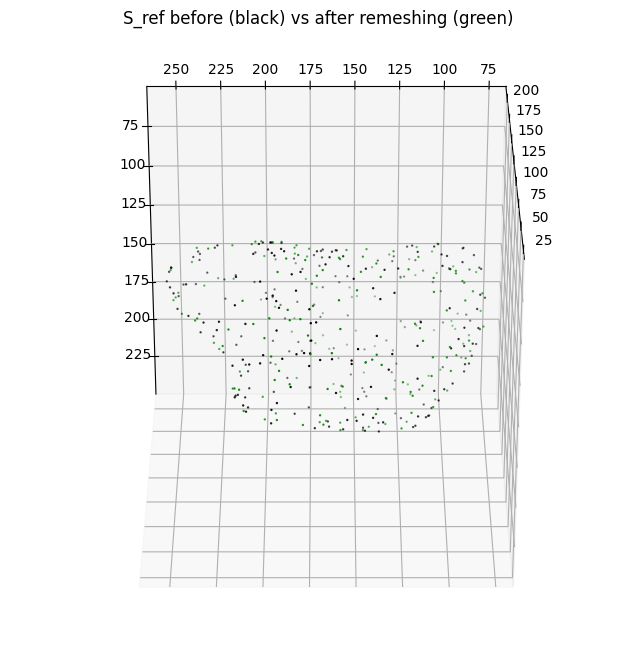

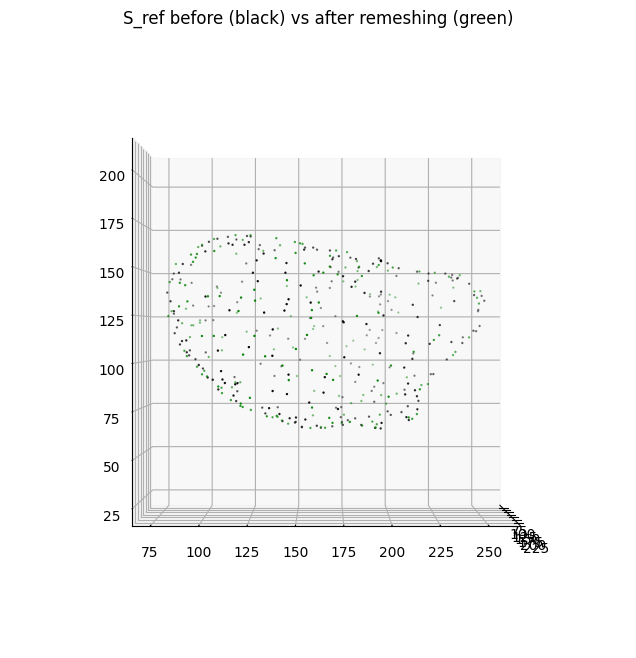

In [24]:
import unwrap3D.Visualisation.plotting as plotting # we import this so we can make x,y,z axes be plotted in equal proportions. 
import pylab as plt 

sampling = 100 # plot every just so its not fully dense in the plot so we don't see anything!

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.title('S_ref before (black) vs after remeshing (green)')
# plotting the before
ax.scatter(cMCF_Sref.vertices[::sampling,2], 
           cMCF_Sref.vertices[::sampling,1],
           cMCF_Sref.vertices[::sampling,0], 
           s=0.5, 
           c='k')
# plotting the after
ax.scatter(cMCF_Sref_remesh.vertices[::sampling,2], 
           cMCF_Sref_remesh.vertices[::sampling,1],
           cMCF_Sref_remesh.vertices[::sampling,0], 
           s=0.5, 
           c='g')
ax.view_init(-60, 180)
plotting.set_axes_equal(ax)
plt.show()


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.title('S_ref before (black) vs after remeshing (green)')
# plotting the before
ax.scatter(cMCF_Sref.vertices[::sampling,2], 
           cMCF_Sref.vertices[::sampling,1],
           cMCF_Sref.vertices[::sampling,0], 
           s=0.5, 
           c='k')
# plotting the after
ax.scatter(cMCF_Sref_remesh.vertices[::sampling,2], 
           cMCF_Sref_remesh.vertices[::sampling,1],
           cMCF_Sref_remesh.vertices[::sampling,0], 
           s=0.5, 
           c='g')
ax.view_init(0, 0)
plotting.set_axes_equal(ax)
plt.show()

In [25]:
import igl 
# measure the geometric differences

# 1. mean squared error or Chamfer distance
mse = meshtools.chamfer_distance_point_cloud(cMCF_Sref.vertices, cMCF_Sref_remesh.vertices)
print('mean squared error (chamfer distance): ', mse) # in terms of pixels 

# 2. diff surface area
diff_A = meshtools.diff_area_trimesh_trimesh(cMCF_Sref, cMCF_Sref_remesh)
fraction_A = diff_A / (np.nansum(igl.doublearea(cMCF_Sref.vertices, cMCF_Sref.faces) /2.))
print('fraction total surface area change: ', fraction_A) 


mean squared error (chamfer distance):  1.7718253
fraction total surface area change:  -0.022664958798817025


#### 8. Mapping measurements onto the genus-0 $S_{ref}(x,y,z)$

The genus-0 $S_{ref}(x,y,z)$ is the tightest approximation of cMCF $S_{ref}(x,y,z)$. Therefore we can establish a 1-1 correspondence by performing mesh matching. This involves finding for every vertex of the genus-0 $S_{ref}(x,y,z)$, the face in cMCF $S_{ref}(x,y,z)$ it will intersect with if we shoot a normal ray to the surface. Where they ray hits can be described by local barycentric coordinates, allowing us to interpolate any measurements of cMCF $S_{ref}(x,y,z)$ by interpolation.

Since cMCF is bijective to the original surface (by virtue of recording the deformation history), $S(x,y,z)$ vertices coordinates can be transfered as measurements onto the genus-0 $S_{ref}(x,y,z)$ like any other signal such as curvature. 


In [26]:
"""
# u-Unwrap3D provides a single convenience function to perform mesh matching between two meshes and then if provided, barycentric interpolation to transfer numerical + label-based measurements
"""

"""
# Example 1: Reinterpolating the surface mean curvature of S(x,y,z) and/or its coloring
"""

# Load the curvature values computed from Step 0
curvature_stats_file = os.path.join(cell_surface_folder, 
                                    '%s_surface_curvature_intensity_stats' %(basefname)) 
surf_H = np.squeeze(spio.loadmat(curvature_stats_file)["surf_H"].copy())

# Get the colors used in S(x,y,z) for curvature and cast to float32 for interpolation
surf_H_colors = mesh.visual.vertex_colors[:,:3].astype(np.float32) 

# performing the matching + transfer
# u-Unwrap3D provides a one-function call for transferring these numerical measurements + label-based measurements 

# concatenate all numerical together, so that number of columns = number of measurements
source_numerical = np.hstack([surf_H[:,None], 
                              surf_H_colors])

# transferring cMCF_Sref to cMCF_Sref_remesh
match_params, transferred_numerical, transferred_labels = meshtools.transfer_mesh_measurements(cMCF_Sref, 
                                                                                               cMCF_Sref_remesh.vertices, 
                                                                                                source_mesh_vertex_scalars=source_numerical,
                                                                                                source_mesh_vertex_labels=None) # we don't have any label measurements

remesh_S_ref_H = transferred_numerical[:,0]
remesh_S_ref_H_color_interp = transferred_numerical[:,1:]


For recoloring the genus-0 $S_\text{ref}(x,y,z)$ we can either apply a colormap to the reinterpolated mean curvature values, or use the interpolated colors directly.

Option 1 is the more accurate, as the generation of the original colormap likely involved clipping the raw values, but involves extra lines of code. Since it is for visualization, option 2 is quicker.

In [27]:
"""
# Option 1: reapply a colormap based on the reinterpolated curvature values, 
"""
remesh_S_ref_H_color = vol_colors.get_colors(remesh_S_ref_H/.104, # .104 is the voxel_size 
                                             colormap=cm.Spectral_r, 
                                             vmin=-1, 
                                             vmax=1) # this gives output in 0-1
remesh_S_ref_H_color = np.uint8(255.*remesh_S_ref_H_color[:,:3])

"""
# Option 2: use interpolated colors
"""
remesh_S_ref_H_color = np.uint8(remesh_S_ref_H_color_interp) # cast back to uint8

"""
add the colors to the cMCF_Sref_remesh and export out a .obj mesh file for visualization
"""
# we now add this color to the remeshed S_ref
cMCF_Sref_remesh.visual.vertex_colors = remesh_S_ref_H_color

tmp = cMCF_Sref_remesh.export(os.path.join(savefolder, 
                                     'unwrap_cMCF_Sref_mesh_H_color.obj'))

# we can also save this remapped curvature value for use in downstream computations e.g. for optimizing the unwrapping axis after spherical parameterization
spio.savemat(os.path.join(savefolder,
                         'unwrap_cMCF_remapped_surf_H.mat'), 
                        {'surf_H' : remesh_S_ref_H})

We show a second example, interpolating the vertex coordinates of $S(x,y,z)$ as a 3-dimensional signal on the genus-0 $S_{\text{ref}}(x,y,z)$ mesh. **Note:** this is in fact a form of parameterization !

number of vertices on genus-0 S_ref geometry:  (18198, 3)
number of vertices in original surface:  (23864, 3)


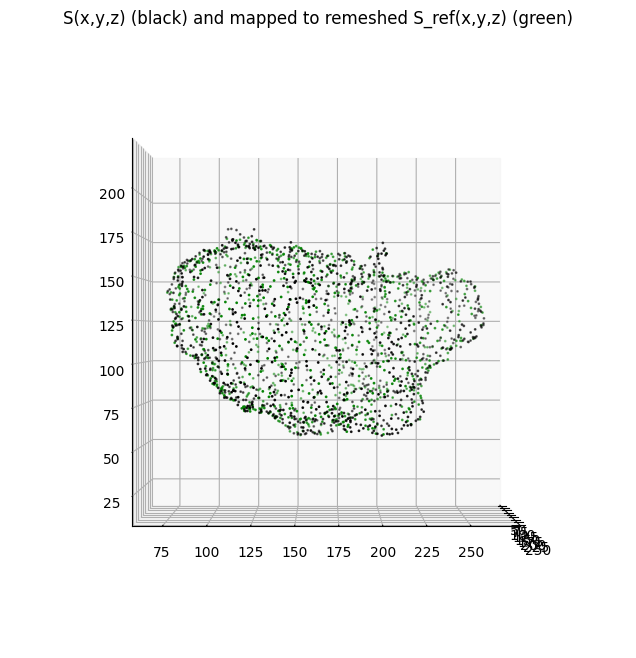

mean squared error (chamfer distance):  1.4446409
fraction total surface area change:  -0.021063772918917697


In [28]:
"""
# Example 2: Reinterpolating the coordinates of S(x,y,z) onto the genus-0 S_ref(x,y,z) by treating it as scalar signals. 
"""

# since in the previous, we performed transfer of the curvature, we can reuse the match_params
remesh_S_ref_input_xyz = meshtools.mesh_vertex_interpolate_scalar(cMCF_Sref, 
                                                                   match_params[0], 
                                                                   match_params[1], 
                                                                   mesh.vertices)

print('number of vertices on genus-0 S_ref geometry: ', remesh_S_ref_input_xyz.shape)
print('number of vertices in original surface: ', mesh.vertices.shape)


# Visualize the colocalization of points. The original mesh will be quasi-conformally mapped.
sampling = 20

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
plt.title('S(x,y,z) (black) and mapped to remeshed S_ref(x,y,z) (green)')
# plotting the before
ax.scatter(mesh.vertices[::sampling,2], 
           mesh.vertices[::sampling,1],
           mesh.vertices[::sampling,0], 
           s=1, 
           c='k')
# plotting the after
ax.scatter(remesh_S_ref_input_xyz[::sampling,2], 
           remesh_S_ref_input_xyz[::sampling,1],
           remesh_S_ref_input_xyz[::sampling,0], 
           s=1, 
           c='g')
ax.view_init(0, 0)
plotting.set_axes_equal(ax)
plt.show()

cMCF_Sref_input_remesh = cMCF_Sref_remesh.copy()
cMCF_Sref_input_remesh.vertices = remesh_S_ref_input_xyz.copy()
tmp = cMCF_Sref_input_remesh.export(os.path.join(savefolder, 
                                             'remapped_input_surface_onto_cMCF_Sref_mesh_H_color.obj'))


# we can quantify the similarity between the transferred coordinates and the actual input surface

# 1. mean squared error or Chamfer distance
mse = meshtools.chamfer_distance_point_cloud(remesh_S_ref_input_xyz, mesh.vertices)
print('mean squared error (chamfer distance): ', mse) # in terms of pixels 

# 2. diff surface area
diff_A = meshtools.diff_area_trimesh_trimesh(cMCF_Sref_input_remesh, mesh)
fraction_A = diff_A / (np.nansum(igl.doublearea(mesh.vertices, mesh.faces) /2.))
print('fraction total surface area change: ', fraction_A) 
  